In [1]:
%run ./replay.ipynb

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import gym
import pybullet_envs
import random
import numpy as np
import tensorflow as tf
import time
from gym.envs.registration import register
from IPython.display import clear_output
from itertools import count

In [3]:
random.seed(2212)
np.random.seed(2212)
tf.random.set_seed(2212)
tf.keras.backend.set_floatx('float64')

In [4]:
env = gym.make('HalfCheetah-v2')
print('observation_space:', env.observation_space.shape)
print('action_space:', env.action_space.shape)
print('action lower:', env.action_space.low)
print('action upper:', env.action_space.high)

observation_space: (17,)
action_space: (6,)
action lower: [-1. -1. -1. -1. -1. -1.]
action upper: [1. 1. 1. 1. 1. 1.]


In [5]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Lambda, concatenate

class Actor:
    def __init__(self, state_dim, action_dim, action_low, action_high):
        last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
        
        inputs = Input((state_dim,))
        hidden = Dense(256, activation='relu')(inputs)
        hidden = Dense(256, activation='relu')(hidden)
        outputs = Dense(action_dim, activation='tanh', kernel_initializer=last_init)(hidden)
        def rescale(x):
            return x * action_high
        outputs = Lambda(rescale)(outputs)
        
        self.model = Model(inputs, outputs)
        
        self.action_low = action_low
        self.action_high = action_high
        
        self.mu = 0.0
        self.sigma = 0.1
        
    def select(self, state, add_noise=True):
        states = np.expand_dims(state, axis=0)
        action = self.model(states)
        if add_noise:
            action += np.random.normal(self.mu, self.sigma, size=action.shape)
            
        action = np.clip(action, self.action_low, self.action_high)
        return action

In [6]:
class Critic:
    def __init__(self, state_dim, action_dim):
        state_in = Input((state_dim,))
        action_in = Input((action_dim,))
        concat = concatenate([state_in, action_in])
        hidden = Dense(256, activation='relu')(concat)
        hidden = Dense(256, activation='relu')(hidden)
        output = Dense(1, activation='linear')(hidden)
        
        self.model = Model([state_in, action_in], output)

In [7]:
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))
        
class Agent:
    def __init__(self, env):
        state_dim = np.squeeze(env.observation_space.shape)
        action_dim = np.squeeze(env.action_space.shape)
        
        self.state_dim, self.action_dim = state_dim, action_dim
        
        action_high = env.action_space.high
        action_low = env.action_space.low
        
        self.critic = Critic(state_dim, action_dim)
        self.actor = Actor(state_dim, action_dim, action_low, action_high)
        
        self.target_critic = Critic(state_dim, action_dim)
        self.update(self.target_critic, self.critic, 1)
        
        self.target_actor = Actor(state_dim, action_dim, action_low, action_high)
        self.update(self.target_actor, self.actor, 1)
        
        self.memory = Memory(1000000)
        self.batch_size = 256
        
        self.total_epochs = 0
        
        self.gamma = 0.99
        
        self.actor_optimizer = tf.keras.optimizers.Adam(lr=1e-3)
        self.critic_optimizer = tf.keras.optimizers.Adam(lr=1e-3)
        
        self.tau = 0.005
        
        self.start_timesteps = int(25e3)
        self.timesteps = 0
        
        self.env = env
        
    def update(self, target, src, tau=None):
        if tau == None:
            tau = self.tau
        if tau == 1:
            target.model.set_weights(src.model.get_weights())
        else:
            update_target(target.model.variables, src.model.variables, tau)
    
    @tf.function
    def update_actor(self, states):
        with tf.GradientTape() as tape:
            actions = self.actor.model(states)
            actor_loss = -tf.reduce_mean(self.critic.model([states, actions]))
            # minus sign to maximize critic value --> max(Q[i])
        actor_grad = tape.gradient(actor_loss, self.actor.model.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.model.trainable_variables))

    @tf.function
    def train(self, states, actions, rewards, next_states, not_dones):
        next_action = self.target_actor.model(next_states)
        
        target_Q = self.target_critic.model([next_states, next_action])
        target_Q = rewards + self.gamma * target_Q * not_dones
        
        with tf.GradientTape() as tape:
            Q = self.critic.model([states, actions])
            loss = tf.reduce_mean(tf.square(target_Q - Q))
        grad = tape.gradient(loss, self.critic.model.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(grad, self.critic.model.trainable_variables))
        
        self.update_actor(states)
        
    def run(self, max_episode=100):
        history = []
        for ep in range(max_episode):
            state = env.reset()
            ep_reward = 0

            for step in count():
                if self.timesteps < self.start_timesteps:
                    action = self.env.action_space.sample()
                else:
                    action = self.actor.select(state)[0]
                self.timesteps += 1

                next_state, reward, done, _ = env.step(action)

                self.memory.add((state, action, reward, next_state, 1 - done))

                if len(self.memory.buffer) >= self.batch_size and self.timesteps > self.start_timesteps:
                    self.total_epochs += 1
                    samples = self.memory.replay(self.batch_size)

                    states, actions, rewards, next_states, not_dones = samples
                    self.train(states, actions, rewards, next_states, not_dones)
                    
                    self.update(self.target_critic, self.critic)
                    self.update(self.target_actor, self.actor)

                ep_reward += reward

                if done:
                    break
                state = next_state

            history.append(ep_reward)
            print('Episode: {}, ep_reward: {}, step: {}'.format(ep, ep_reward, step + 1))

        return history

In [8]:
agent = Agent(env)

In [9]:
history = agent.run(3000)

Episode: 0, ep_reward: -206.43580274859423, step: 1000
Episode: 1, ep_reward: -197.59289360526236, step: 1000
Episode: 2, ep_reward: -258.2566769983504, step: 1000
Episode: 3, ep_reward: -232.64876913577845, step: 1000
Episode: 4, ep_reward: -224.57088485714812, step: 1000
Episode: 5, ep_reward: -436.5638314542203, step: 1000
Episode: 6, ep_reward: -228.83298694345274, step: 1000
Episode: 7, ep_reward: -169.059193400655, step: 1000
Episode: 8, ep_reward: -363.68659560339427, step: 1000
Episode: 9, ep_reward: -246.41924994984748, step: 1000
Episode: 10, ep_reward: -317.8395543201468, step: 1000
Episode: 11, ep_reward: -411.95554158266594, step: 1000
Episode: 12, ep_reward: -375.76630557265037, step: 1000
Episode: 13, ep_reward: -283.41026972689593, step: 1000
Episode: 14, ep_reward: -292.3353156295617, step: 1000
Episode: 15, ep_reward: -552.1117441706049, step: 1000
Episode: 16, ep_reward: -196.54656253340193, step: 1000
Episode: 17, ep_reward: -208.78736971348033, step: 1000
Episode: 

Episode: 150, ep_reward: 3872.1579317041333, step: 1000
Episode: 151, ep_reward: 3897.2389937035077, step: 1000
Episode: 152, ep_reward: 3933.8858130601106, step: 1000
Episode: 153, ep_reward: 3443.369929653706, step: 1000
Episode: 154, ep_reward: 4025.625778955039, step: 1000
Episode: 155, ep_reward: 3545.7357686467194, step: 1000
Episode: 156, ep_reward: 3486.5376694224797, step: 1000
Episode: 157, ep_reward: 4048.1321510660287, step: 1000
Episode: 158, ep_reward: 4204.081047753162, step: 1000
Episode: 159, ep_reward: 3881.41424227953, step: 1000
Episode: 160, ep_reward: 4131.8529645464205, step: 1000
Episode: 161, ep_reward: 3906.085888591791, step: 1000
Episode: 162, ep_reward: 4171.003964156782, step: 1000
Episode: 163, ep_reward: 4061.3293709966615, step: 1000
Episode: 164, ep_reward: 3874.060012044844, step: 1000
Episode: 165, ep_reward: 4144.2794051517385, step: 1000
Episode: 166, ep_reward: 4172.9133125128, step: 1000
Episode: 167, ep_reward: 3859.1871781780474, step: 1000
Epi

Episode: 299, ep_reward: 4902.719956318996, step: 1000
Episode: 300, ep_reward: 4650.548933123703, step: 1000
Episode: 301, ep_reward: 4602.888853141674, step: 1000
Episode: 302, ep_reward: 4329.223503859029, step: 1000
Episode: 303, ep_reward: 4533.749934706636, step: 1000
Episode: 304, ep_reward: 4092.3917225137743, step: 1000
Episode: 305, ep_reward: 4723.172900557401, step: 1000
Episode: 306, ep_reward: 499.3758237795807, step: 1000
Episode: 307, ep_reward: 4306.70393472985, step: 1000
Episode: 308, ep_reward: 3407.507707001356, step: 1000
Episode: 309, ep_reward: 2914.4378577756183, step: 1000
Episode: 310, ep_reward: 4259.246496532178, step: 1000
Episode: 311, ep_reward: 4855.868952100815, step: 1000
Episode: 312, ep_reward: 4326.681062749814, step: 1000
Episode: 313, ep_reward: 3824.6768015535977, step: 1000
Episode: 314, ep_reward: 4246.347629726134, step: 1000
Episode: 315, ep_reward: 4399.648451034165, step: 1000
Episode: 316, ep_reward: 4421.8740058651365, step: 1000
Episode

Episode: 448, ep_reward: 5402.867252738207, step: 1000
Episode: 449, ep_reward: 5313.152366482305, step: 1000
Episode: 450, ep_reward: 4610.878266735732, step: 1000
Episode: 451, ep_reward: 5317.482166032789, step: 1000
Episode: 452, ep_reward: 4683.066470689981, step: 1000
Episode: 453, ep_reward: 5011.549124475742, step: 1000
Episode: 454, ep_reward: 5439.3615336595285, step: 1000
Episode: 455, ep_reward: 388.11627495953996, step: 1000
Episode: 456, ep_reward: 5190.876594110102, step: 1000
Episode: 457, ep_reward: 5138.102323646098, step: 1000
Episode: 458, ep_reward: 5042.03740808049, step: 1000
Episode: 459, ep_reward: 4820.35716567985, step: 1000
Episode: 460, ep_reward: 4857.3042196972465, step: 1000
Episode: 461, ep_reward: 994.7689021158186, step: 1000
Episode: 462, ep_reward: 4430.867645634483, step: 1000
Episode: 463, ep_reward: 4049.7992375484027, step: 1000
Episode: 464, ep_reward: 5497.798686919081, step: 1000
Episode: 465, ep_reward: 2388.953293323352, step: 1000
Episode:

Episode: 597, ep_reward: 5187.525591853678, step: 1000
Episode: 598, ep_reward: 5589.752864285284, step: 1000
Episode: 599, ep_reward: 4751.502969253375, step: 1000
Episode: 600, ep_reward: 5073.2343058698125, step: 1000
Episode: 601, ep_reward: 5343.858169490254, step: 1000
Episode: 602, ep_reward: 5654.164226624975, step: 1000
Episode: 603, ep_reward: 4855.799115053111, step: 1000
Episode: 604, ep_reward: 5535.068769899959, step: 1000
Episode: 605, ep_reward: 4825.6041561640695, step: 1000
Episode: 606, ep_reward: 5391.051124402599, step: 1000
Episode: 607, ep_reward: 4256.666587520458, step: 1000
Episode: 608, ep_reward: 5194.416531667912, step: 1000
Episode: 609, ep_reward: 5324.562887646637, step: 1000
Episode: 610, ep_reward: 4753.37102225277, step: 1000
Episode: 611, ep_reward: 5436.064228409772, step: 1000
Episode: 612, ep_reward: 5072.320300218248, step: 1000
Episode: 613, ep_reward: 5374.216585847104, step: 1000
Episode: 614, ep_reward: 4977.495854308973, step: 1000
Episode: 

Episode: 746, ep_reward: 5790.7701834875315, step: 1000
Episode: 747, ep_reward: 5665.383637469002, step: 1000
Episode: 748, ep_reward: 5241.452688432992, step: 1000
Episode: 749, ep_reward: 5576.606956489805, step: 1000
Episode: 750, ep_reward: 5815.599846569567, step: 1000
Episode: 751, ep_reward: 5295.189391157554, step: 1000
Episode: 752, ep_reward: 5550.661394827112, step: 1000
Episode: 753, ep_reward: 5785.2601606211865, step: 1000
Episode: 754, ep_reward: 4902.914931538126, step: 1000
Episode: 755, ep_reward: 5767.266961560073, step: 1000
Episode: 756, ep_reward: 4837.327066906814, step: 1000
Episode: 757, ep_reward: 5891.928475133293, step: 1000
Episode: 758, ep_reward: 5260.503322887976, step: 1000
Episode: 759, ep_reward: 5686.50164719347, step: 1000
Episode: 760, ep_reward: 5257.151456991027, step: 1000
Episode: 761, ep_reward: 5411.043771503823, step: 1000
Episode: 762, ep_reward: 5970.098000852279, step: 1000
Episode: 763, ep_reward: 5732.531166928008, step: 1000
Episode: 

Episode: 896, ep_reward: 5832.9697685702195, step: 1000
Episode: 897, ep_reward: 5482.580998014326, step: 1000
Episode: 898, ep_reward: 6115.723703876221, step: 1000
Episode: 899, ep_reward: 5709.969715420749, step: 1000
Episode: 900, ep_reward: 5182.229706353443, step: 1000
Episode: 901, ep_reward: 5419.37716414444, step: 1000
Episode: 902, ep_reward: 5198.906145808036, step: 1000
Episode: 903, ep_reward: 5768.009486364769, step: 1000
Episode: 904, ep_reward: 5224.664780727369, step: 1000
Episode: 905, ep_reward: 4981.126777290507, step: 1000
Episode: 906, ep_reward: 5086.3386517631125, step: 1000
Episode: 907, ep_reward: 5805.593317959404, step: 1000
Episode: 908, ep_reward: 6062.547902168479, step: 1000
Episode: 909, ep_reward: 5606.970822982267, step: 1000
Episode: 910, ep_reward: 5807.8291746737905, step: 1000
Episode: 911, ep_reward: 4180.905512859459, step: 1000
Episode: 912, ep_reward: 5539.861654307414, step: 1000
Episode: 913, ep_reward: 5819.06210236191, step: 1000
Episode: 

Episode: 1045, ep_reward: 4395.224239770784, step: 1000
Episode: 1046, ep_reward: 5659.598639685954, step: 1000
Episode: 1047, ep_reward: 6051.078340653168, step: 1000
Episode: 1048, ep_reward: 5322.965091813485, step: 1000
Episode: 1049, ep_reward: 5067.356614593169, step: 1000
Episode: 1050, ep_reward: 5626.448351506926, step: 1000
Episode: 1051, ep_reward: 5683.45796678346, step: 1000
Episode: 1052, ep_reward: 5789.562402442936, step: 1000
Episode: 1053, ep_reward: 6230.573803721671, step: 1000
Episode: 1054, ep_reward: 6121.870170676681, step: 1000
Episode: 1055, ep_reward: 5222.273079566536, step: 1000
Episode: 1056, ep_reward: 5305.366569476269, step: 1000
Episode: 1057, ep_reward: 5978.879013808766, step: 1000
Episode: 1058, ep_reward: 6220.82355538829, step: 1000
Episode: 1059, ep_reward: 5688.359543603672, step: 1000
Episode: 1060, ep_reward: 5988.924792418841, step: 1000
Episode: 1061, ep_reward: 6257.334916350993, step: 1000
Episode: 1062, ep_reward: 5979.029139967358, step:

Episode: 1192, ep_reward: 6107.76669359585, step: 1000
Episode: 1193, ep_reward: 5826.832678928781, step: 1000
Episode: 1194, ep_reward: 6024.7963864489975, step: 1000
Episode: 1195, ep_reward: 5563.850412636782, step: 1000
Episode: 1196, ep_reward: 4914.619428943898, step: 1000
Episode: 1197, ep_reward: 6262.480108548277, step: 1000
Episode: 1198, ep_reward: 6166.700396931477, step: 1000
Episode: 1199, ep_reward: 6006.151008314069, step: 1000
Episode: 1200, ep_reward: 5472.105043036335, step: 1000
Episode: 1201, ep_reward: 5172.6760415062845, step: 1000
Episode: 1202, ep_reward: 6386.80739134761, step: 1000
Episode: 1203, ep_reward: 6172.516110820063, step: 1000
Episode: 1204, ep_reward: 6121.927246178469, step: 1000
Episode: 1205, ep_reward: 6371.055170569545, step: 1000
Episode: 1206, ep_reward: 5382.261751273752, step: 1000
Episode: 1207, ep_reward: 6070.200058073913, step: 1000
Episode: 1208, ep_reward: 6448.001321786672, step: 1000
Episode: 1209, ep_reward: 6091.225017592424, ste

Episode: 1339, ep_reward: 5971.82506358095, step: 1000
Episode: 1340, ep_reward: 6336.901460814725, step: 1000
Episode: 1341, ep_reward: 6182.168977231426, step: 1000
Episode: 1342, ep_reward: 6151.802037900859, step: 1000
Episode: 1343, ep_reward: 6601.385840360376, step: 1000
Episode: 1344, ep_reward: 5987.586826800855, step: 1000
Episode: 1345, ep_reward: 6432.699852110766, step: 1000
Episode: 1346, ep_reward: 6625.046924523594, step: 1000
Episode: 1347, ep_reward: 6170.733663614137, step: 1000
Episode: 1348, ep_reward: 5976.88653430158, step: 1000
Episode: 1349, ep_reward: 6613.139172444751, step: 1000
Episode: 1350, ep_reward: 6585.532684856087, step: 1000
Episode: 1351, ep_reward: 6285.21699693346, step: 1000
Episode: 1352, ep_reward: 6451.812462181221, step: 1000
Episode: 1353, ep_reward: 6525.174130159228, step: 1000
Episode: 1354, ep_reward: 6619.42264834366, step: 1000
Episode: 1355, ep_reward: 6283.977163911057, step: 1000
Episode: 1356, ep_reward: 6329.425698725157, step: 1

Episode: 1486, ep_reward: 6502.0418060891825, step: 1000
Episode: 1487, ep_reward: 6682.388332559256, step: 1000
Episode: 1488, ep_reward: 6262.037159647021, step: 1000
Episode: 1489, ep_reward: 7021.170955000411, step: 1000
Episode: 1490, ep_reward: 4796.372072873035, step: 1000
Episode: 1491, ep_reward: 6129.44621327803, step: 1000
Episode: 1492, ep_reward: 6742.018251350285, step: 1000
Episode: 1493, ep_reward: 6707.194377864577, step: 1000
Episode: 1494, ep_reward: 6690.986178610993, step: 1000
Episode: 1495, ep_reward: 6540.433615173692, step: 1000
Episode: 1496, ep_reward: 6305.852757785116, step: 1000
Episode: 1497, ep_reward: 6505.153081953843, step: 1000
Episode: 1498, ep_reward: 6546.420539411619, step: 1000
Episode: 1499, ep_reward: 6511.699611128453, step: 1000
Episode: 1500, ep_reward: 6266.086076909713, step: 1000
Episode: 1501, ep_reward: 6823.866210361974, step: 1000
Episode: 1502, ep_reward: 6191.3369169989, step: 1000
Episode: 1503, ep_reward: 6236.408553563221, step:

Episode: 1633, ep_reward: 6360.61718234821, step: 1000
Episode: 1634, ep_reward: 7327.7671153477995, step: 1000
Episode: 1635, ep_reward: 6522.936234237175, step: 1000
Episode: 1636, ep_reward: 6413.779465696221, step: 1000
Episode: 1637, ep_reward: 6563.435967793965, step: 1000
Episode: 1638, ep_reward: 6546.042027280196, step: 1000
Episode: 1639, ep_reward: 6719.153513732203, step: 1000
Episode: 1640, ep_reward: 6656.291503831897, step: 1000
Episode: 1641, ep_reward: 4595.953204609375, step: 1000
Episode: 1642, ep_reward: 5702.262554484123, step: 1000
Episode: 1643, ep_reward: 6538.746195136755, step: 1000
Episode: 1644, ep_reward: 5801.521177108384, step: 1000
Episode: 1645, ep_reward: 6974.567161169099, step: 1000
Episode: 1646, ep_reward: 6664.22617524518, step: 1000
Episode: 1647, ep_reward: 6640.606425661308, step: 1000
Episode: 1648, ep_reward: 5965.389157194595, step: 1000
Episode: 1649, ep_reward: 6003.216579464147, step: 1000
Episode: 1650, ep_reward: 6490.455047338657, step

Episode: 1780, ep_reward: 1463.5244718534248, step: 1000
Episode: 1781, ep_reward: 5907.879823449353, step: 1000
Episode: 1782, ep_reward: 6377.414920745987, step: 1000
Episode: 1783, ep_reward: 6561.045884701904, step: 1000
Episode: 1784, ep_reward: 6491.105088338982, step: 1000
Episode: 1785, ep_reward: 6855.325643566394, step: 1000
Episode: 1786, ep_reward: 5689.627235620526, step: 1000
Episode: 1787, ep_reward: 6560.748198636666, step: 1000
Episode: 1788, ep_reward: 7025.32126230039, step: 1000
Episode: 1789, ep_reward: 6193.041884819837, step: 1000
Episode: 1790, ep_reward: 6882.044097627392, step: 1000
Episode: 1791, ep_reward: 6889.928494561419, step: 1000
Episode: 1792, ep_reward: 7130.256925012737, step: 1000
Episode: 1793, ep_reward: 6606.431234152372, step: 1000
Episode: 1794, ep_reward: 6852.464516216393, step: 1000
Episode: 1795, ep_reward: 6177.640523035728, step: 1000
Episode: 1796, ep_reward: 6763.827755818061, step: 1000
Episode: 1797, ep_reward: 6224.364273206209, ste

Episode: 1927, ep_reward: 7377.6417433030865, step: 1000
Episode: 1928, ep_reward: 6155.620633548594, step: 1000
Episode: 1929, ep_reward: 6653.226655453583, step: 1000
Episode: 1930, ep_reward: 7046.236720471473, step: 1000
Episode: 1931, ep_reward: 6992.573550613292, step: 1000
Episode: 1932, ep_reward: 6352.2340161458105, step: 1000
Episode: 1933, ep_reward: 6931.021446143677, step: 1000
Episode: 1934, ep_reward: 4944.21424905829, step: 1000
Episode: 1935, ep_reward: 6072.757893372829, step: 1000
Episode: 1936, ep_reward: 7092.730770041662, step: 1000
Episode: 1937, ep_reward: 6499.369849764294, step: 1000
Episode: 1938, ep_reward: 7222.45118833416, step: 1000
Episode: 1939, ep_reward: 6268.414745104174, step: 1000
Episode: 1940, ep_reward: 6448.489806758175, step: 1000
Episode: 1941, ep_reward: 7071.519504465781, step: 1000
Episode: 1942, ep_reward: 6615.895818540927, step: 1000
Episode: 1943, ep_reward: 7148.171942897061, step: 1000
Episode: 1944, ep_reward: 6318.683730410994, ste

Episode: 2074, ep_reward: 6834.887886050968, step: 1000
Episode: 2075, ep_reward: 6756.609285487821, step: 1000
Episode: 2076, ep_reward: 6950.482858337779, step: 1000
Episode: 2077, ep_reward: 6648.912345193145, step: 1000
Episode: 2078, ep_reward: 7084.652714707246, step: 1000
Episode: 2079, ep_reward: 7108.03026490631, step: 1000
Episode: 2080, ep_reward: 6065.775870946927, step: 1000
Episode: 2081, ep_reward: 6644.063081831245, step: 1000
Episode: 2082, ep_reward: 5751.808745229601, step: 1000
Episode: 2083, ep_reward: 7135.173127545478, step: 1000
Episode: 2084, ep_reward: 6866.199636071729, step: 1000
Episode: 2085, ep_reward: 7093.029748493223, step: 1000
Episode: 2086, ep_reward: 6495.753301996135, step: 1000
Episode: 2087, ep_reward: 6829.140705564024, step: 1000
Episode: 2088, ep_reward: 5875.626675825325, step: 1000
Episode: 2089, ep_reward: 5898.269897248727, step: 1000
Episode: 2090, ep_reward: 6822.667214609894, step: 1000
Episode: 2091, ep_reward: 4708.0432070006345, ste

Episode: 2221, ep_reward: 7025.809673389753, step: 1000
Episode: 2222, ep_reward: 7022.710506491136, step: 1000
Episode: 2223, ep_reward: 6768.159296969675, step: 1000
Episode: 2224, ep_reward: 6889.8739574988385, step: 1000
Episode: 2225, ep_reward: 6188.8872635445405, step: 1000
Episode: 2226, ep_reward: 6678.906566802124, step: 1000
Episode: 2227, ep_reward: 5899.935312955102, step: 1000
Episode: 2228, ep_reward: 7211.455692248368, step: 1000
Episode: 2229, ep_reward: 6855.373738760512, step: 1000
Episode: 2230, ep_reward: 6599.779023375035, step: 1000
Episode: 2231, ep_reward: 6275.574480884125, step: 1000
Episode: 2232, ep_reward: 5826.950639968389, step: 1000
Episode: 2233, ep_reward: 6794.514761888322, step: 1000
Episode: 2234, ep_reward: 6053.449098336785, step: 1000
Episode: 2235, ep_reward: 7086.905142670783, step: 1000
Episode: 2236, ep_reward: 7122.939957543939, step: 1000
Episode: 2237, ep_reward: 6060.110992597099, step: 1000
Episode: 2238, ep_reward: 6666.7604645739, ste

Episode: 2368, ep_reward: 7187.927260769324, step: 1000
Episode: 2369, ep_reward: 6746.931563393765, step: 1000
Episode: 2370, ep_reward: 6827.207776409015, step: 1000
Episode: 2371, ep_reward: 6842.655601214616, step: 1000
Episode: 2372, ep_reward: 7053.966637378055, step: 1000
Episode: 2373, ep_reward: 6823.210395967118, step: 1000
Episode: 2374, ep_reward: 7101.713021989279, step: 1000
Episode: 2375, ep_reward: 6443.858233962614, step: 1000
Episode: 2376, ep_reward: 6975.303258099691, step: 1000
Episode: 2377, ep_reward: 6820.828001532949, step: 1000
Episode: 2378, ep_reward: 414.5158004267641, step: 1000
Episode: 2379, ep_reward: 7134.5324154996415, step: 1000
Episode: 2380, ep_reward: 6462.36932153678, step: 1000
Episode: 2381, ep_reward: 7116.125908498497, step: 1000
Episode: 2382, ep_reward: 5751.851630786096, step: 1000
Episode: 2383, ep_reward: 7272.392304473615, step: 1000
Episode: 2384, ep_reward: 6456.106819436662, step: 1000
Episode: 2385, ep_reward: 6030.818873430845, ste

Episode: 2515, ep_reward: 6855.726917964991, step: 1000
Episode: 2516, ep_reward: 6854.162002154193, step: 1000
Episode: 2517, ep_reward: 7028.407933162525, step: 1000
Episode: 2518, ep_reward: 7125.674237937153, step: 1000
Episode: 2519, ep_reward: 6501.655174350305, step: 1000
Episode: 2520, ep_reward: 7218.348461664874, step: 1000
Episode: 2521, ep_reward: 6965.6304436170185, step: 1000
Episode: 2522, ep_reward: 7205.325747306178, step: 1000
Episode: 2523, ep_reward: 6746.466357906932, step: 1000
Episode: 2524, ep_reward: 7308.821829641884, step: 1000
Episode: 2525, ep_reward: 7873.769674495296, step: 1000
Episode: 2526, ep_reward: 7372.418385233646, step: 1000
Episode: 2527, ep_reward: 6928.859032714716, step: 1000
Episode: 2528, ep_reward: 7409.077346732256, step: 1000
Episode: 2529, ep_reward: 7362.3395540035035, step: 1000
Episode: 2530, ep_reward: 7212.225494583079, step: 1000
Episode: 2531, ep_reward: 3017.406840733565, step: 1000
Episode: 2532, ep_reward: 7199.24429284198, st

Episode: 2661, ep_reward: 7039.644905109976, step: 1000
Episode: 2662, ep_reward: 7341.108115011974, step: 1000
Episode: 2663, ep_reward: 7104.901864789506, step: 1000
Episode: 2664, ep_reward: 6225.652881193028, step: 1000
Episode: 2665, ep_reward: 6992.3994454974345, step: 1000
Episode: 2666, ep_reward: 5735.209436451277, step: 1000
Episode: 2667, ep_reward: 5896.250296886538, step: 1000
Episode: 2668, ep_reward: 7567.798023737657, step: 1000
Episode: 2669, ep_reward: 2263.2979869897968, step: 1000
Episode: 2670, ep_reward: 7094.749489754945, step: 1000
Episode: 2671, ep_reward: 6820.586469224586, step: 1000
Episode: 2672, ep_reward: 1337.9518333316337, step: 1000
Episode: 2673, ep_reward: 6915.114080695514, step: 1000
Episode: 2674, ep_reward: 7970.135977755666, step: 1000
Episode: 2675, ep_reward: 1020.569943741274, step: 1000
Episode: 2676, ep_reward: 7243.698416474719, step: 1000
Episode: 2677, ep_reward: 7046.259817148603, step: 1000
Episode: 2678, ep_reward: 7120.96769736354, s

Episode: 2808, ep_reward: 7368.288817262564, step: 1000
Episode: 2809, ep_reward: 5949.5885534369845, step: 1000
Episode: 2810, ep_reward: 7322.145393566897, step: 1000
Episode: 2811, ep_reward: 7311.536307458639, step: 1000
Episode: 2812, ep_reward: 6880.114207690707, step: 1000
Episode: 2813, ep_reward: 7180.068780317094, step: 1000
Episode: 2814, ep_reward: 7276.095412189969, step: 1000
Episode: 2815, ep_reward: 7027.6583741541, step: 1000
Episode: 2816, ep_reward: 7187.86628194553, step: 1000
Episode: 2817, ep_reward: 6995.547129315166, step: 1000
Episode: 2818, ep_reward: 7500.687136312522, step: 1000
Episode: 2819, ep_reward: 6863.559327611469, step: 1000
Episode: 2820, ep_reward: 7519.011662253352, step: 1000
Episode: 2821, ep_reward: 7798.184596914722, step: 1000
Episode: 2822, ep_reward: 5226.989431485839, step: 1000
Episode: 2823, ep_reward: 6960.94174457567, step: 1000
Episode: 2824, ep_reward: 7046.154193123537, step: 1000
Episode: 2825, ep_reward: 5813.422096457899, step: 

Episode: 2955, ep_reward: 7111.297379425541, step: 1000
Episode: 2956, ep_reward: 7236.7293848657555, step: 1000
Episode: 2957, ep_reward: 6395.291297779288, step: 1000
Episode: 2958, ep_reward: 4696.101648253173, step: 1000
Episode: 2959, ep_reward: 6971.8027544037195, step: 1000
Episode: 2960, ep_reward: 6265.503809029635, step: 1000
Episode: 2961, ep_reward: 7389.788549445041, step: 1000
Episode: 2962, ep_reward: 7253.5386952939225, step: 1000
Episode: 2963, ep_reward: 6362.924028445885, step: 1000
Episode: 2964, ep_reward: 7024.9842655688035, step: 1000
Episode: 2965, ep_reward: 8090.316377542736, step: 1000
Episode: 2966, ep_reward: 7996.353183305126, step: 1000
Episode: 2967, ep_reward: 6942.040272008244, step: 1000
Episode: 2968, ep_reward: 7322.0048518494705, step: 1000
Episode: 2969, ep_reward: 7420.045450672821, step: 1000
Episode: 2970, ep_reward: 6930.735875659996, step: 1000
Episode: 2971, ep_reward: 7317.824024832511, step: 1000
Episode: 2972, ep_reward: 7794.164267648895

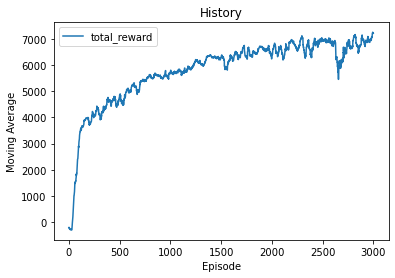

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(data, avg_span=30):
    fig1, ax1 = plt.subplots()
    for title, history in data:
        x = range(len(history))
        cumsum = np.cumsum(history)
        avgs = [cumsum[ep]/(ep+1) if ep<avg_span else (cumsum[ep]-cumsum[ep-avg_span])/avg_span for ep in x]
        ax1.plot(x, avgs, label=title)
    ax1.set_title("History")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Moving Average")
    ax1.legend()

plot([
    ('total_reward', history),
])